# Algorithmic Trading Model for Cramer COVID-19 Index Using Python Take 1
### David Lowe
### May 29, 2020

SUMMARY: The purpose of this project is to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: CNBC’s Jim Cramer, the host of Mad Money show, presented a list of stocks on April 27th that he believes will work well in this coronavirus-plagued market. The "Cramer COVID-19 Broad Index" contains 100 companies that touch 17 sectors where investors can expect a positive return in this volatile market environment. The project aims to analyze these 100 stocks and develop strategies for trading these stocks, either individually or in groups.

In this Take1 iteration, we will construct the necessary code segments for downloading and visualizing the index and the stocks. The script will leverage various data sources, both free and paid subscriptions, for pulling the required dataset together.

NOTE: This script calculates the index value by using the number of outstanding shares from each company. Such an approach may not match how CNBC calculates this index (https://www.cnbc.com/cramer-covid-19-stocks/). This script is for educational purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

ANALYSIS: Not applicable for this iteration.

CONCLUSION: Not applicable for this iteration.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Yahoo Finance, IEX Cloud, and Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Develop Strategy and Train Model
4. Back-test Model
5. Evaluate Performance

## Task 1. Prepare Environment

In [1]:
import os
import sys
import smtplib
import numpy as np
import pandas as pd
import requests
import json
from email.message import EmailMessage
import matplotlib.pyplot as plt
from datetime import datetime
from time import sleep
import pandas_datareader.data as pdr
from dotenv import load_dotenv

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Define the function for sending the status notification emails
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if (sender is None) or (receiver is None) or (gateway is None) or (smtpuser is None) or (password is None):
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Algorithmic Trading Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [3]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useDocker = True
if not useDocker:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 120)
pd.set_option("display.width", 140)

In [4]:
if notifyStatus: email_notify("Task 1. Prepare Environment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [5]:
# Check and see whether the API key is available
alphavantage_key = os.environ.get('ALPHAVANTAGE_API')
if alphavantage_key is None: sys.exit("API key for Alpha Vantage not available. Script Processing Aborted!!!")

# Check and see whether the API key is available
iexcloud_key = os.environ.get('IEXCLOUD_API')
if iexcloud_key is None: sys.exit("API key for IEX Cloud not available. Script Processing Aborted!!!")

# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [6]:
model_start_date = datetime(2020, 4, 24)
print("Starting date for the model:", model_start_date)
model_end_date = datetime.now()
# model_end_date = datetime(2020, 1, 1)
print("Ending date for the model:", model_end_date)

Starting date for the model: 2020-04-24 00:00:00
Ending date for the model: 2020-05-28 19:08:32.765154


In [7]:
if notifyStatus: email_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2. Acquire and Pre-Process Data

In [8]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [9]:
dataset_path = 'https://www.dainesanalytics.com/datasets/cramer-covid19-index/Cramer_COVID-19_Index.csv'
stockIndex = pd.read_csv(dataset_path, sep=',')
stockIndex.set_index('Symbol', inplace=True)
stockIndex = stockIndex.sort_index(ascending = True)

# Take a peek at the dataframe after import
stockIndex.head(10)

,Name
Symbol,
AAPL,Apple
ABBV,AbbVie
ABT,Abbott Labs
ADBE,Adobe
AKAM,Akamai Technologies
AMD,Advanced Micro Devices
AMT,American Tower
AMZN,Amazon
ATVI,Activision Blizzard


In [10]:
stock_list = stockIndex.index.tolist()
if verbose: print('Stocks to process:', stock_list)

In [11]:
for ticker in stock_list:
    iexcloud_url = "https://cloud.iexapis.com/stable/stock/%s/stats/sharesOutstanding?token=%s" % (ticker, iexcloud_key)
    sleep(1)
    response = requests.get(iexcloud_url)
    share_data = json.loads(response.text)
    stockIndex.loc[ticker,'Share_Outstanding'] = share_data
    print('Company share data retrieved for:', ticker, share_data)

Company share data retrieved for: AAPL 4334340000
Company share data retrieved for: ABBV 1762340000
Company share data retrieved for: ABT 1768850000
Company share data retrieved for: ADBE 481801000
Company share data retrieved for: AKAM 162274000
Company share data retrieved for: AMD 1171190000
Company share data retrieved for: AMT 443306000
Company share data retrieved for: AMZN 498776000
Company share data retrieved for: ATVI 770486000
Company share data retrieved for: BAX 508836000
Company share data retrieved for: BNTX 228604644
Company share data retrieved for: BSX 1399350000
Company share data retrieved for: BYND 62236700
Company share data retrieved for: CAG 487076000
Company share data retrieved for: CCI 416751000
Company share data retrieved for: CHGG 123646000
Company share data retrieved for: CHWY 66479000
Company share data retrieved for: CL 856528000
Company share data retrieved for: CLX 125100000
Company share data retrieved for: CMG 27890700
Company share data retrieved 

In [12]:
stockIndex.head(10)

,Name,Share_Outstanding
Symbol,,
AAPL,Apple,4.334340e+09
ABBV,AbbVie,1.762340e+09
ABT,Abbott Labs,1.768850e+09
ADBE,Adobe,4.818010e+08
AKAM,Akamai Technologies,1.622740e+08
AMD,Advanced Micro Devices,1.171190e+09
AMT,American Tower,4.433060e+08
AMZN,Amazon,4.987760e+08
ATVI,Activision Blizzard,7.704860e+08


In [13]:
total_shares = stockIndex['Share_Outstanding'].sum()

In [14]:
# Create the master dataframe to hold the index and individual stock data
date_index = pd.date_range(start=model_start_date, end=model_end_date)
columns = ['JC_MAD']
index_df = pd.DataFrame(index=date_index, columns=columns)
index_df = index_df.fillna(0.0)
index_df.head()

,JC_MAD
2020-04-24,0.0
2020-04-25,0.0
2020-04-26,0.0
2020-04-27,0.0
2020-04-28,0.0


In [15]:
index_df.tail()

,JC_MAD
2020-05-24,0.0
2020-05-25,0.0
2020-05-26,0.0
2020-05-27,0.0
2020-05-28,0.0


In [16]:
start_date_string = model_start_date.strftime('%Y-%m-%d')
end_date_string = model_end_date.strftime('%Y-%m-%d')

for ticker in stock_list:
    quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, ticker, quandl_key)
    response = requests.get(quandl_url)
    sleep(1)
    quandl_dict = json.loads(response.text)
    stock_data = pd.DataFrame(quandl_dict['datatable']['data'])
    print(len(stock_data), 'data points retrieved from the API call for:', ticker)
    stock_data.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
    stock_data.index = pd.to_datetime(stock_data.date)
    stock_data = stock_data.sort_index(ascending = True)
    stock_close = stock_data.loc[:, ['closeunadj']] * stockIndex.loc[ticker, 'Share_Outstanding'] / total_shares
    stock_close.rename(columns={'closeunadj': ticker}, inplace=True)
    index_df = pd.concat([index_df, stock_close], axis=1)

index_df.dropna(inplace=True)
index_df['JC_MAD'] = index_df[stock_list].sum(axis=1)

23 data points retrieved from the API call for: AAPL
23 data points retrieved from the API call for: ABBV
23 data points retrieved from the API call for: ABT
23 data points retrieved from the API call for: ADBE
23 data points retrieved from the API call for: AKAM
23 data points retrieved from the API call for: AMD
23 data points retrieved from the API call for: AMT
23 data points retrieved from the API call for: AMZN
23 data points retrieved from the API call for: ATVI
23 data points retrieved from the API call for: BAX
23 data points retrieved from the API call for: BNTX
23 data points retrieved from the API call for: BSX
23 data points retrieved from the API call for: BYND
23 data points retrieved from the API call for: CAG
23 data points retrieved from the API call for: CCI
23 data points retrieved from the API call for: CHGG
23 data points retrieved from the API call for: CHWY
23 data points retrieved from the API call for: CL
23 data points retrieved from the API call for: CLX
23 

In [17]:
index_df.head(10)

,JC_MAD,AAPL,ABBV,ABT,ADBE,AKAM,AMD,AMT,AMZN,ATVI,...,UNH,VEEV,VZ,WING,WIX,WMT,WORK,ZM,ZS,ZTS
2020-04-24,142.363530,16.814815,2.019634,2.280997,2.272904,0.228658,0.902065,1.486642,16.481281,0.704034,...,3.787361,0.346867,3.286418,0.046231,0.094913,5.028646,0.152015,0.364789,0.119703,0.819839
2020-04-27,142.669780,16.826700,2.046212,2.302580,2.301968,0.229303,0.907043,1.520738,16.247282,0.708365,...,3.822336,0.343095,3.279610,0.045846,0.093599,4.984358,0.159307,0.378113,0.124970,0.829671
2020-04-28,139.918914,16.553950,1.999581,2.217946,2.202557,0.226767,0.891307,1.480079,15.823868,0.674563,...,3.749265,0.337827,3.280744,0.046868,0.090314,4.972704,0.156798,0.360011,0.118320,0.800891
2020-04-29,142.506178,17.097667,2.023742,2.237831,2.306393,0.217735,0.861602,1.439237,16.224784,0.684387,...,3.740033,0.348567,3.297196,0.047906,0.094828,4.801767,0.157907,0.336488,0.118160,0.817495
2020-04-30,143.478908,17.458362,1.986050,2.233224,2.335919,0.217379,0.841210,1.446470,16.917414,0.673190,...,3.802703,0.352727,3.259187,0.047562,0.092405,4.722126,0.155690,0.310507,0.118958,0.841978
2020-05-01,140.161549,17.177293,2.001513,2.178903,2.271187,0.213263,0.800908,1.423375,15.632128,0.683647,...,3.699207,0.347126,3.224014,0.047935,0.087722,4.775349,0.153882,0.318295,0.118550,0.830387
2020-05-04,141.935253,17.420331,1.977835,2.178418,2.305997,0.217134,0.843940,1.438143,15.836928,0.704562,...,3.738603,0.349658,3.190542,0.048738,0.088788,4.805652,0.158665,0.329505,0.122505,0.829801
2020-05-05,143.808257,17.681791,2.062641,2.256019,2.352366,0.220671,0.837999,1.460205,15.849305,0.723893,...,3.810114,0.356535,3.205860,0.049050,0.093493,4.845666,0.159190,0.332675,0.126318,0.854935
2020-05-06,144.168629,17.864218,2.063849,2.208731,2.394575,0.220627,0.837517,1.441972,16.078108,0.769737,...,3.754596,0.356720,3.156504,0.049878,0.101525,4.790112,0.161173,0.343632,0.128641,0.818407
2020-05-07,145.310911,18.049023,2.034856,2.279299,2.422714,0.223808,0.834145,1.429756,16.189910,0.772166,...,3.705578,0.353559,3.153100,0.049886,0.105890,4.735335,0.174706,0.362492,0.132791,0.808965


In [18]:
index_df.tail(10)

,JC_MAD,AAPL,ABBV,ABT,ADBE,AKAM,AMD,AMT,AMZN,ATVI,...,UNH,VEEV,VZ,WING,WIX,WMT,WORK,ZM,ZS,ZTS
2020-05-13,145.505274,18.281365,2.147205,2.234921,2.368418,0.212173,0.837838,1.404838,16.192030,0.778187,...,3.614564,0.360769,3.111687,0.048730,0.117405,4.806040,0.176165,0.383947,0.133287,0.801086
2020-05-14,146.307660,18.393674,2.173058,2.225706,2.347479,0.216311,0.875250,1.395539,16.335151,0.770687,...,3.778519,0.362396,3.115090,0.049444,0.133928,4.794774,0.184681,0.385716,0.134103,0.820620
2020-05-15,147.705166,18.284930,2.191662,2.179873,2.412938,0.218224,0.870273,1.395296,16.478272,0.780828,...,3.783070,0.370530,3.103744,0.051512,0.142539,4.892674,0.182756,0.401613,0.135469,0.830127
2020-05-18,149.056561,18.715744,2.210025,2.189088,2.430574,0.218246,0.876535,1.434497,16.590964,0.769842,...,3.814275,0.364503,3.161042,0.049285,0.136873,4.959495,0.169165,0.378319,0.130893,0.855716
2020-05-19,147.988971,18.607595,2.203501,2.139374,2.458515,0.216466,0.890665,1.397666,16.748718,0.771427,...,3.758236,0.362414,3.085023,0.049062,0.135404,4.854213,0.173190,0.398971,0.133429,0.874729
2020-05-20,149.651834,18.969479,2.203259,2.184723,2.534014,0.223764,0.905437,1.398700,17.081117,0.779349,...,3.744454,0.373746,3.078215,0.049740,0.143379,4.873638,0.182873,0.403106,0.136657,0.868218
2020-05-21,148.164646,18.828053,2.247474,2.191998,2.524370,0.224698,0.877498,1.386666,16.731008,0.765512,...,3.730412,0.365058,3.061763,0.049172,0.146092,4.855767,0.184565,0.395180,0.134121,0.848619
2020-05-22,148.922376,18.949275,2.225246,2.218188,2.544781,0.223408,0.885848,1.473393,16.663584,0.771955,...,3.769808,0.375207,3.069138,0.049164,0.152026,4.830127,0.184973,0.392952,0.136444,0.847187
2020-05-26,147.509756,18.820922,2.191662,2.169930,2.487776,0.222651,0.854055,1.482510,16.560876,0.739421,...,3.834168,0.360713,3.080485,0.048259,0.148176,4.811868,0.189056,0.376734,0.135699,0.849400
2020-05-27,147.957303,18.902926,2.174024,2.200970,2.478133,0.222406,0.846830,1.531617,16.482443,0.741005,...,3.949626,0.354927,3.128139,0.048612,0.145492,4.758256,0.187306,0.372071,0.132170,0.883194


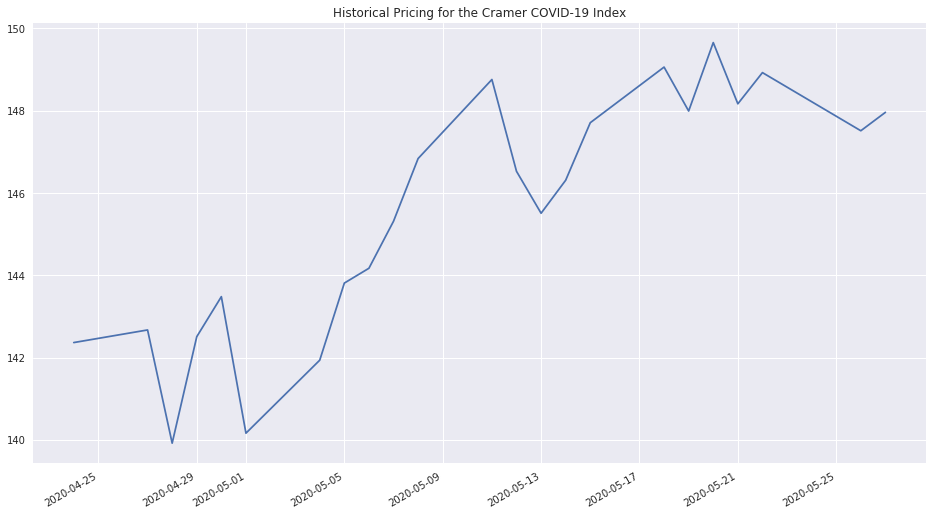

In [19]:
title_string = 'Historical Pricing for the Cramer COVID-19 Index'
index_df['JC_MAD'].plot(figsize=(16,9), title=title_string)
plt.show()

In [20]:
return_df = index_df[['JC_MAD']].copy()
# return_df['MAD_DAILY_RETURN'] = np.log(return_df['JC_MAD']/return_df['JC_MAD'].shift(1))
return_df['MAD_DAILY_RETURN'] = return_df['JC_MAD'].pct_change()
base = return_df.iloc[0]['JC_MAD']
return_df['MAD_ACCUM_RETURN'] = (return_df['JC_MAD'] - base) / base
return_df.head(10)

,JC_MAD,MAD_DAILY_RETURN,MAD_ACCUM_RETURN
2020-04-24,142.363530,NaN,0.000000
2020-04-27,142.669780,0.002151,0.002151
2020-04-28,139.918914,-0.019281,-0.017172
2020-04-29,142.506178,0.018491,0.001002
2020-04-30,143.478908,0.006826,0.007835
2020-05-01,140.161549,-0.023121,-0.015467
2020-05-04,141.935253,0.012655,-0.003008
2020-05-05,143.808257,0.013196,0.010148
2020-05-06,144.168629,0.002506,0.012680
2020-05-07,145.310911,0.007923,0.020703


In [21]:
market_list = ['^DJI', '^GSPC', '^IXIC', '^NDX']
import yfinance as yf
yf.pdr_override()

for symbol in market_list:
    market_data = pdr.get_data_yahoo(symbol, model_start_date, model_end_date)
    print(len(market_data), 'data points retrieved from the API call for:', symbol)
    market_close = market_data.loc[:, ['Adj Close']]
    market_symbol = symbol.lstrip("^")
    market_close.rename(columns={'Adj Close': market_symbol}, inplace=True)
    return_df = pd.concat([return_df, market_close], axis=1)
    daily_column_string = market_symbol + "_DAILY_RETURN"
#     return_df[daily_column_string] = np.log(return_df[market_symbol]/return_df[market_symbol].shift(1))
    return_df[daily_column_string] = return_df[market_symbol].pct_change()
    accum_column_string = market_symbol + "_ACCUM_RETURN"
    base = return_df.iloc[0][market_symbol]
    return_df[accum_column_string] = (return_df[market_symbol] - base) / base

[*********************100%***********************]  1 of 1 completed
24 data points retrieved from the API call for: ^DJI
[*********************100%***********************]  1 of 1 completed
24 data points retrieved from the API call for: ^GSPC
[*********************100%***********************]  1 of 1 completed
24 data points retrieved from the API call for: ^IXIC
[*********************100%***********************]  1 of 1 completed
24 data points retrieved from the API call for: ^NDX


In [22]:
return_df.dropna(inplace=True)
return_df.head(10)

,JC_MAD,MAD_DAILY_RETURN,MAD_ACCUM_RETURN,DJI,DJI_DAILY_RETURN,DJI_ACCUM_RETURN,GSPC,GSPC_DAILY_RETURN,GSPC_ACCUM_RETURN,IXIC,IXIC_DAILY_RETURN,IXIC_ACCUM_RETURN,NDX,NDX_DAILY_RETURN,NDX_ACCUM_RETURN
2020-04-27,142.669780,0.002151,0.002151,24133.779297,0.015079,0.015079,2878.479980,0.014714,0.014714,8730.160156,0.011077,0.011077,8837.660156,0.005811,0.005811
2020-04-28,139.918914,-0.019281,-0.017172,24101.550781,-0.001335,0.013724,2863.389893,-0.005242,0.009395,8607.730469,-0.014024,-0.003103,8677.599609,-0.018111,-0.012405
2020-04-29,142.506178,0.018491,0.001002,24633.859375,0.022086,0.036113,2939.510010,0.026584,0.036228,8914.709961,0.035663,0.032450,8982.759766,0.035166,0.022325
2020-04-30,143.478908,0.006826,0.007835,24345.720703,-0.011697,0.023993,2912.429932,-0.009212,0.026682,8889.549805,-0.002822,0.029536,9000.509766,0.001976,0.024345
2020-05-01,140.161549,-0.023121,-0.015467,23723.689453,-0.025550,-0.002169,2830.709961,-0.028059,-0.002126,8604.950195,-0.032015,-0.003425,8718.179688,-0.031368,-0.007787
2020-05-04,141.935253,0.012655,-0.003008,23749.759766,0.001099,-0.001073,2842.739990,0.004250,0.002115,8710.709961,0.012291,0.008824,8834.110352,0.013298,0.005407
2020-05-05,143.808257,0.013196,0.010148,23883.089844,0.005614,0.004535,2868.439941,0.009041,0.011175,8809.120117,0.011298,0.020221,8930.620117,0.010925,0.016391
2020-05-06,144.168629,0.002506,0.012680,23664.640625,-0.009147,-0.004653,2848.419922,-0.006979,0.004117,8854.389648,0.005139,0.025464,8984.860352,0.006074,0.022564
2020-05-07,145.310911,0.007923,0.020703,23875.890625,0.008927,0.004232,2881.189941,0.011505,0.015669,8979.660156,0.014148,0.039972,9101.879883,0.013024,0.035882
2020-05-08,146.834823,0.010487,0.031408,24331.320312,0.019075,0.023388,2929.800049,0.016872,0.032805,9121.320312,0.015776,0.056378,9220.349609,0.013016,0.049365


In [23]:
return_df.tail(10)

,JC_MAD,MAD_DAILY_RETURN,MAD_ACCUM_RETURN,DJI,DJI_DAILY_RETURN,DJI_ACCUM_RETURN,GSPC,GSPC_DAILY_RETURN,GSPC_ACCUM_RETURN,IXIC,IXIC_DAILY_RETURN,IXIC_ACCUM_RETURN,NDX,NDX_DAILY_RETURN,NDX_ACCUM_RETURN
2020-05-13,145.505274,-0.006958,0.022068,23247.970703,-0.021747,-0.022178,2820.000000,-0.017463,-0.005901,8863.169922,-0.015482,0.026481,9000.080078,-0.012331,0.024296
2020-05-14,146.307660,0.005514,0.027705,23625.339844,0.016232,-0.006306,2852.500000,0.011525,0.005556,8943.719727,0.009088,0.035810,9094.419922,0.010482,0.035033
2020-05-15,147.705166,0.009552,0.037521,23685.419922,0.002543,-0.003779,2863.699951,0.003926,0.009504,9014.559570,0.007921,0.044014,9152.639648,0.006402,0.041659
2020-05-18,149.056561,0.009149,0.047014,24597.369141,0.038503,0.034578,2953.909912,0.031501,0.041304,9234.830078,0.024435,0.069524,9331.929688,0.019589,0.062064
2020-05-19,147.988971,-0.007162,0.039515,24206.859375,-0.015876,0.018153,2922.939941,-0.010484,0.030387,9185.099609,-0.005385,0.063765,9298.540039,-0.003578,0.058264
2020-05-20,149.651834,0.011236,0.051195,24575.900391,0.015245,0.033675,2971.610107,0.016651,0.047544,9375.780273,0.020760,0.085849,9485.019531,0.020055,0.079487
2020-05-21,148.164646,-0.009938,0.040749,24474.119141,-0.004142,0.029394,2948.510010,-0.007774,0.039401,9284.879883,-0.009695,0.075321,9377.990234,-0.011284,0.067306
2020-05-22,148.922376,0.005114,0.046071,24465.160156,-0.000366,0.029017,2955.449951,0.002354,0.041847,9324.589844,0.004277,0.079920,9413.990234,0.003839,0.071403
2020-05-26,147.509756,-0.009486,0.036148,24995.109375,0.021661,0.051307,2991.770020,0.012289,0.054651,9340.219727,0.001676,0.081730,9389.980469,-0.002550,0.068671
2020-05-27,147.957303,0.003034,0.039292,25548.269531,0.022131,0.074573,3036.129883,0.014827,0.070288,9412.360352,0.007724,0.090085,9442.049805,0.005545,0.074597


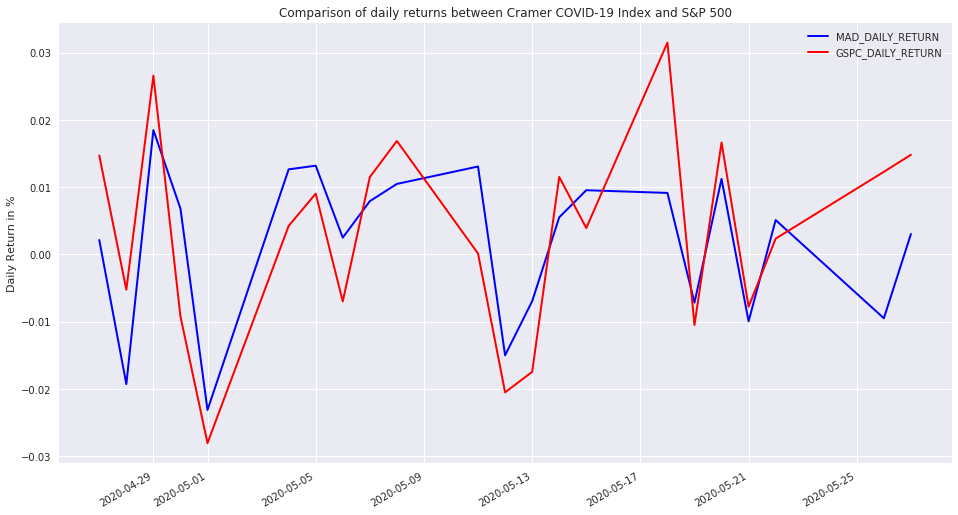

In [24]:
title_string = 'Comparison of daily returns between Cramer COVID-19 Index and S&P 500'
fig = plt.figure(figsize=(16,9))
ylabel = 'Daily Return in %'
ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
return_df['MAD_DAILY_RETURN'].plot(ax=ax1, color='b', lw=2.)
return_df['GSPC_DAILY_RETURN'].plot(ax=ax1, color='r', lw=2.)
plt.legend()
plt.show()

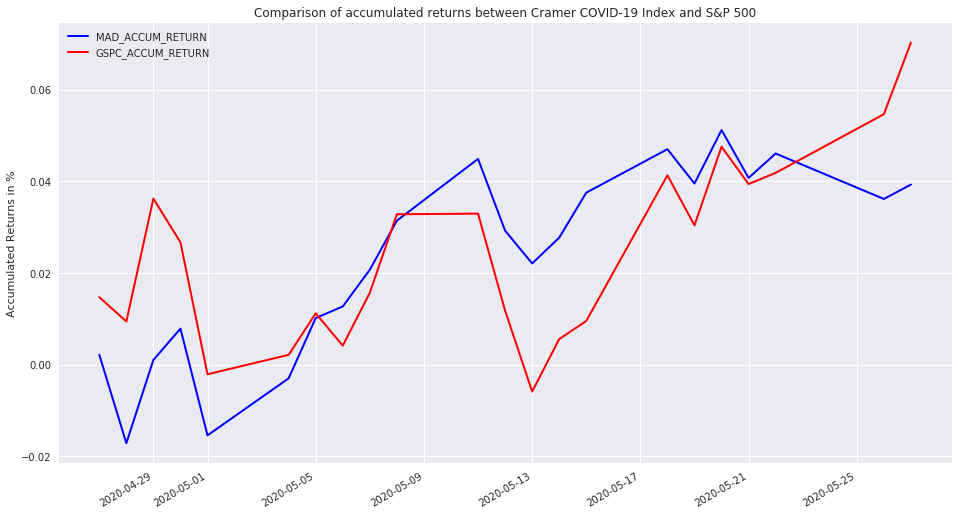

In [25]:
title_string = 'Comparison of accumulated returns between Cramer COVID-19 Index and S&P 500'
fig, ax1 = plt.subplots(figsize=(16,9))
plt.title(title_string)
ax1.set_ylabel('Accumulated Returns in %')
return_df['MAD_ACCUM_RETURN'].plot(ax=ax1, color='b', lw=2.)
return_df['GSPC_ACCUM_RETURN'].plot(ax=ax1, color='r', lw=2.)
plt.legend()
plt.show()

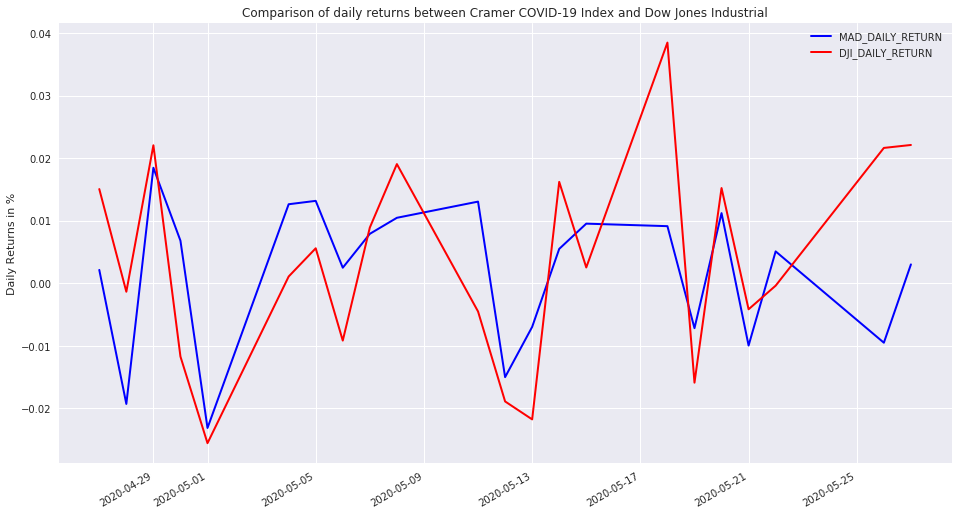

In [26]:
title_string = 'Comparison of daily returns between Cramer COVID-19 Index and Dow Jones Industrial'
fig = plt.figure(figsize=(16,9))
ylabel = 'Daily Returns in %'
ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
return_df['MAD_DAILY_RETURN'].plot(ax=ax1, color='b', lw=2.)
return_df['DJI_DAILY_RETURN'].plot(ax=ax1, color='r', lw=2.)
plt.legend()
plt.show()

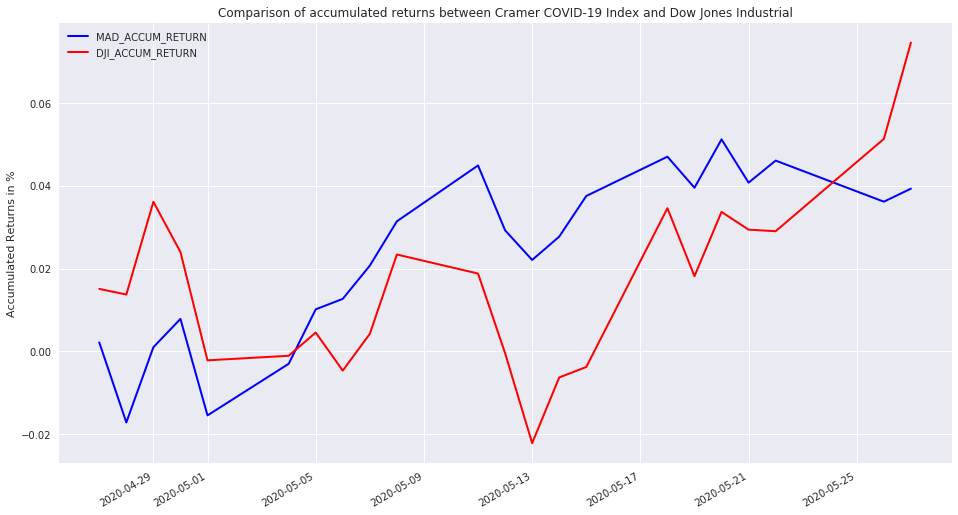

In [27]:
title_string = 'Comparison of accumulated returns between Cramer COVID-19 Index and Dow Jones Industrial'
fig, ax1 = plt.subplots(figsize=(16,9))
plt.title(title_string)
ax1.set_ylabel('Accumulated Returns in %')
return_df['MAD_ACCUM_RETURN'].plot(ax=ax1, color='b', lw=2.)
return_df['DJI_ACCUM_RETURN'].plot(ax=ax1, color='r', lw=2.)
plt.legend()
plt.show()

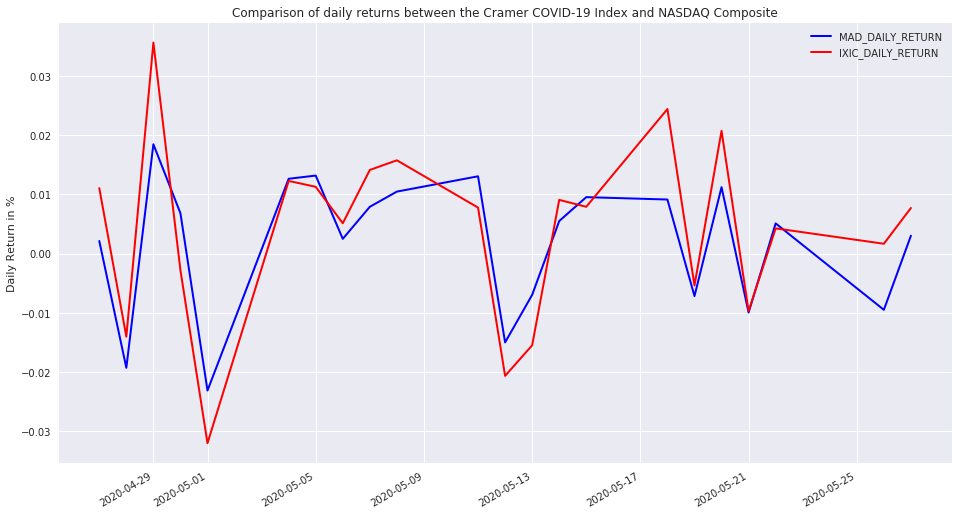

In [28]:
title_string = 'Comparison of daily returns between the Cramer COVID-19 Index and NASDAQ Composite'
fig = plt.figure(figsize=(16,9))
ylabel = 'Daily Return in %'
ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
return_df['MAD_DAILY_RETURN'].plot(ax=ax1, color='b', lw=2.)
return_df['IXIC_DAILY_RETURN'].plot(ax=ax1, color='r', lw=2.)
plt.legend()
plt.show()

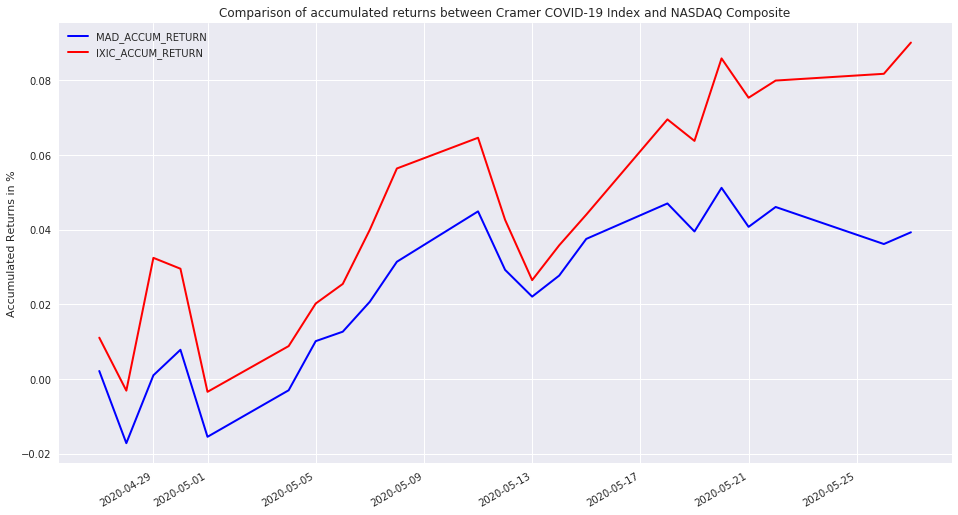

In [29]:
title_string = 'Comparison of accumulated returns between Cramer COVID-19 Index and NASDAQ Composite'
fig, ax1 = plt.subplots(figsize=(16,9))
plt.title(title_string)
ax1.set_ylabel('Accumulated Returns in %')
return_df['MAD_ACCUM_RETURN'].plot(ax=ax1, color='b', lw=2.)
return_df['IXIC_ACCUM_RETURN'].plot(ax=ax1, color='r', lw=2.)
plt.legend()
plt.show()

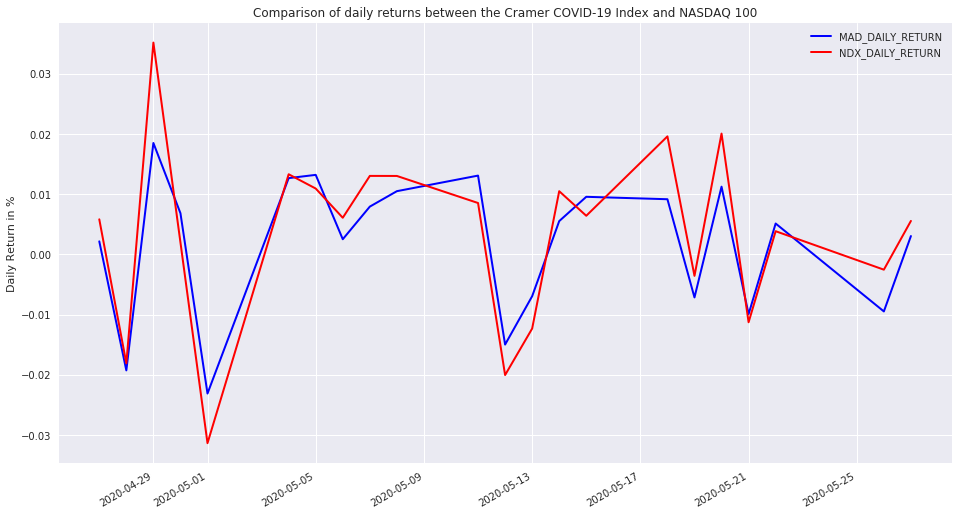

In [30]:
title_string = 'Comparison of daily returns between the Cramer COVID-19 Index and NASDAQ 100'
fig = plt.figure(figsize=(16,9))
ylabel = 'Daily Return in %'
ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
return_df['MAD_DAILY_RETURN'].plot(ax=ax1, color='b', lw=2.)
return_df['NDX_DAILY_RETURN'].plot(ax=ax1, color='r', lw=2.)
plt.legend()
plt.show()

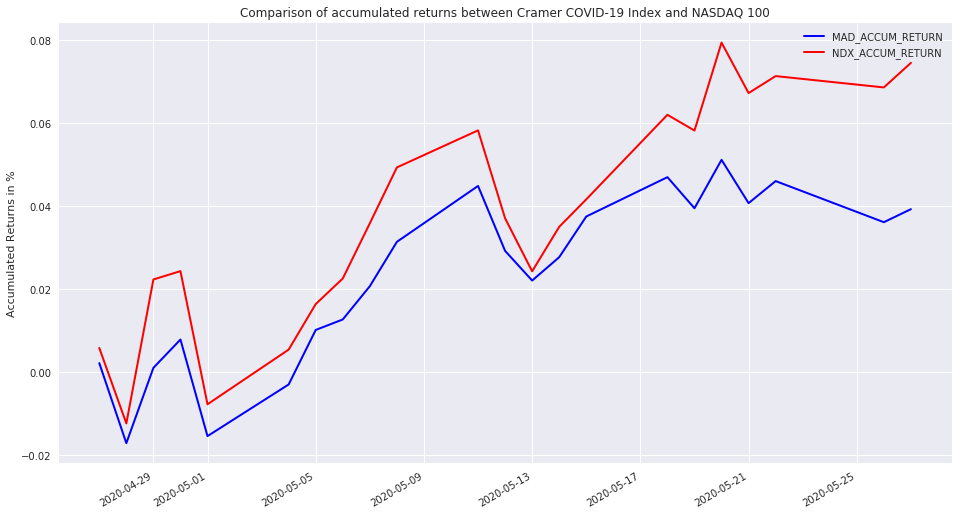

In [31]:
title_string = 'Comparison of accumulated returns between Cramer COVID-19 Index and NASDAQ 100'
fig, ax1 = plt.subplots(figsize=(16,9))
plt.title(title_string)
ax1.set_ylabel('Accumulated Returns in %')
return_df['MAD_ACCUM_RETURN'].plot(ax=ax1, color='b', lw=2.)
return_df['NDX_ACCUM_RETURN'].plot(ax=ax1, color='r', lw=2.)
plt.legend()
plt.show()

In [32]:
print('The accumulated return/loss from the Cramer COVID-19 Index: %.2f percent' % (return_df.iloc[-1]['MAD_ACCUM_RETURN'] * 100))
print('The accumulated return/loss from the S&P 500 Index: %.2f percent' % (return_df.iloc[-1]['GSPC_ACCUM_RETURN'] * 100))
print('The accumulated return/loss from the Dow Jones Industrial Index: %.2f percent' % (return_df.iloc[-1]['DJI_ACCUM_RETURN'] * 100))
print('The accumulated return/loss from the NASDAQ Composite Index: %.2f percent' % (return_df.iloc[-1]['IXIC_ACCUM_RETURN'] * 100))
print('The accumulated return/loss from the NASDAQ 100 Index: %.2f percent' % (return_df.iloc[-1]['NDX_ACCUM_RETURN'] * 100))

The accumulated return/loss from the Cramer COVID-19 Index: 3.93 percent
The accumulated return/loss from the S&P 500 Index: 7.03 percent
The accumulated return/loss from the Dow Jones Industrial Index: 7.46 percent
The accumulated return/loss from the NASDAQ Composite Index: 9.01 percent
The accumulated return/loss from the NASDAQ 100 Index: 7.46 percent


In [33]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3. Develop Strategy and Train Model

In [34]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [35]:
# Not applicable for this iteration of the project

In [36]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4. Back-test Model

In [37]:
if notifyStatus: email_notify("Task 4. Back-test Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [38]:
# Not applicable for this iteration of the project

In [39]:
if notifyStatus: email_notify("Task 4. Back-test Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5. Evaluate Performance

In [40]:
if notifyStatus: email_notify("Task 5. Evaluate Performance has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [41]:
# Not applicable for this iteration of the project

In [42]:
if notifyStatus: email_notify("Task 5. Evaluate Performance completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [43]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:05:23.039252
